# Contribution profiles in real networks 

In [2]:
from pathlib import Path
import random
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from msb import Balance

#%matplotlib inline
sns.set_theme(
    context="notebook",
    style="ticks",
    font_scale=1.3,
    palette="deep"
)

COLORS = np.array(["#7aa063", "#c86b57", "#9d6ebd"])
RED    = "#f97959"
BLUE   = "#60a1f7"
GRAY   = "#efefef"

# Paths
ROOT = Path(".").absolute().parent
DATA = ROOT/"data"
FIGS = ROOT/"figs"
FIGS.mkdir(exist_ok=True)

# Balance params
BKWS = dict(m=10, kmin=2)

LABELS = {
    "new-guinea-tribes":   "Tribes",
    "epinions-trust":      "Epinions",
    "wikipedia-elections": "Wikipedia",
    "slashdot-zoo":        "Slashdot",
    "sampson/t1":          "Sampson (1)",
    "sampson/t2":          "Sampson (2)",
    "sampson/t3":          "Sampson (3)",
    "sampson/t4":          "Sampson (4)",
    "sampson/t5":          "Sampson (5)",
}

def preprocess(graph, weights=True):
    if not weights:
        graph.es["weight"] = np.sign(graph.es["weight"])
    return graph

NETWORKS = {}
for n in LABELS:
    graph = ig.Graph.Read_GraphMLz(DATA/f"{n}.graphml.gz")
    NETWORKS[n] = preprocess(graph, weights=True)

/home/sztal/.conda/envs/msb/lib/python3.10/site-packages/igraph/io/files.py:189: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  return cls.Read_GraphML(tmpfile, index=index)


In [29]:
from msb.cycleindex import balance_ratio

# G = NETWORKS["wikipedia-elections"]
G = NETWORKS["new-guinea-tribes"]
A = np.array(list(G.get_adjacency(attribute="weight")))
A

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [-1., -1.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [34]:
b0 = balance_ratio(A, 15, exact=False)
b0

TypeError: 'float' object cannot be interpreted as an integer

In [32]:
Balance(G).contrib()

beta      K 
0.031398  2     3.435746e-01
          3     3.435746e-01
          4     1.929084e-01
          5     7.788903e-02
          6     2.915363e-02
          7     9.334436e-03
          8     2.678495e-03
          9     6.860331e-04
          10    1.591496e-04
          11    3.363887e-05
          12    6.530510e-06
          13    1.171391e-06
          14    1.952401e-07
          15    3.038352e-08
          16    4.433925e-09
          17    6.090808e-10
          18    7.902783e-11
          19    9.714712e-12
          20    1.134540e-12
          21    1.261917e-13
          22    1.339815e-14
          23    1.360686e-15
          24    1.324311e-16
          25    1.237357e-17
          26    1.111649e-18
          27    9.617243e-20
          28    8.023054e-21
          29    6.462329e-22
          30    5.031707e-23
Name: contrib, dtype: float64

In [24]:
b1 = Balance(G).local_balance()

df = pd.DataFrame({
    "b0": 1 - b0[2:],
    "b1": b1,
    "contrib": Balance(G).contrib().to_numpy()
})
df.round(5)

,b0,b1,contrib
K,,,
3,0.86765,0.87440,0.31981
4,0.72085,0.83776,0.31981
5,0.62066,0.75067,0.18311
6,0.55528,0.71327,0.10213
7,0.51360,0.66759,0.04638
8,0.48899,0.63974,0.01889
9,0.47667,0.61371,0.00678
10,0.47298,0.59467,0.00220
11,0.47573,0.57835,0.00065


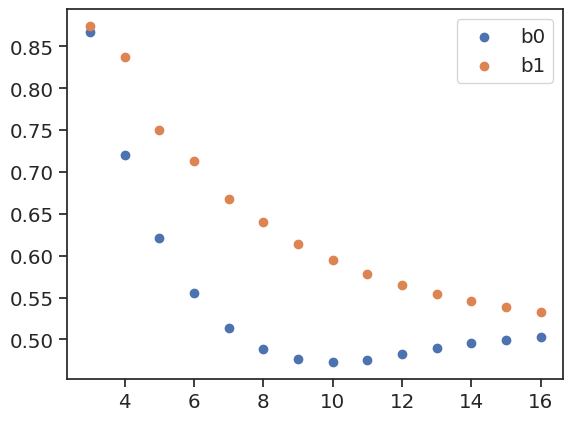

In [36]:
plt.scatter(df.index, df["b0"], label="b0")
plt.scatter(df.index, df["b1"], label="b1")
plt.legend()

In [2]:
## MAKE DATA
BALANCE = {}
for name, graph in tqdm(NETWORKS.items()):
    key = LABELS[name]
    B = Balance(graph, **BKWS)
    BALANCE[key] = (Balance(graph, semi=True), Balance(graph, beta=1, semi=False))

100%|██████████| 9/9 [00:14<00:00,  1.58s/it]


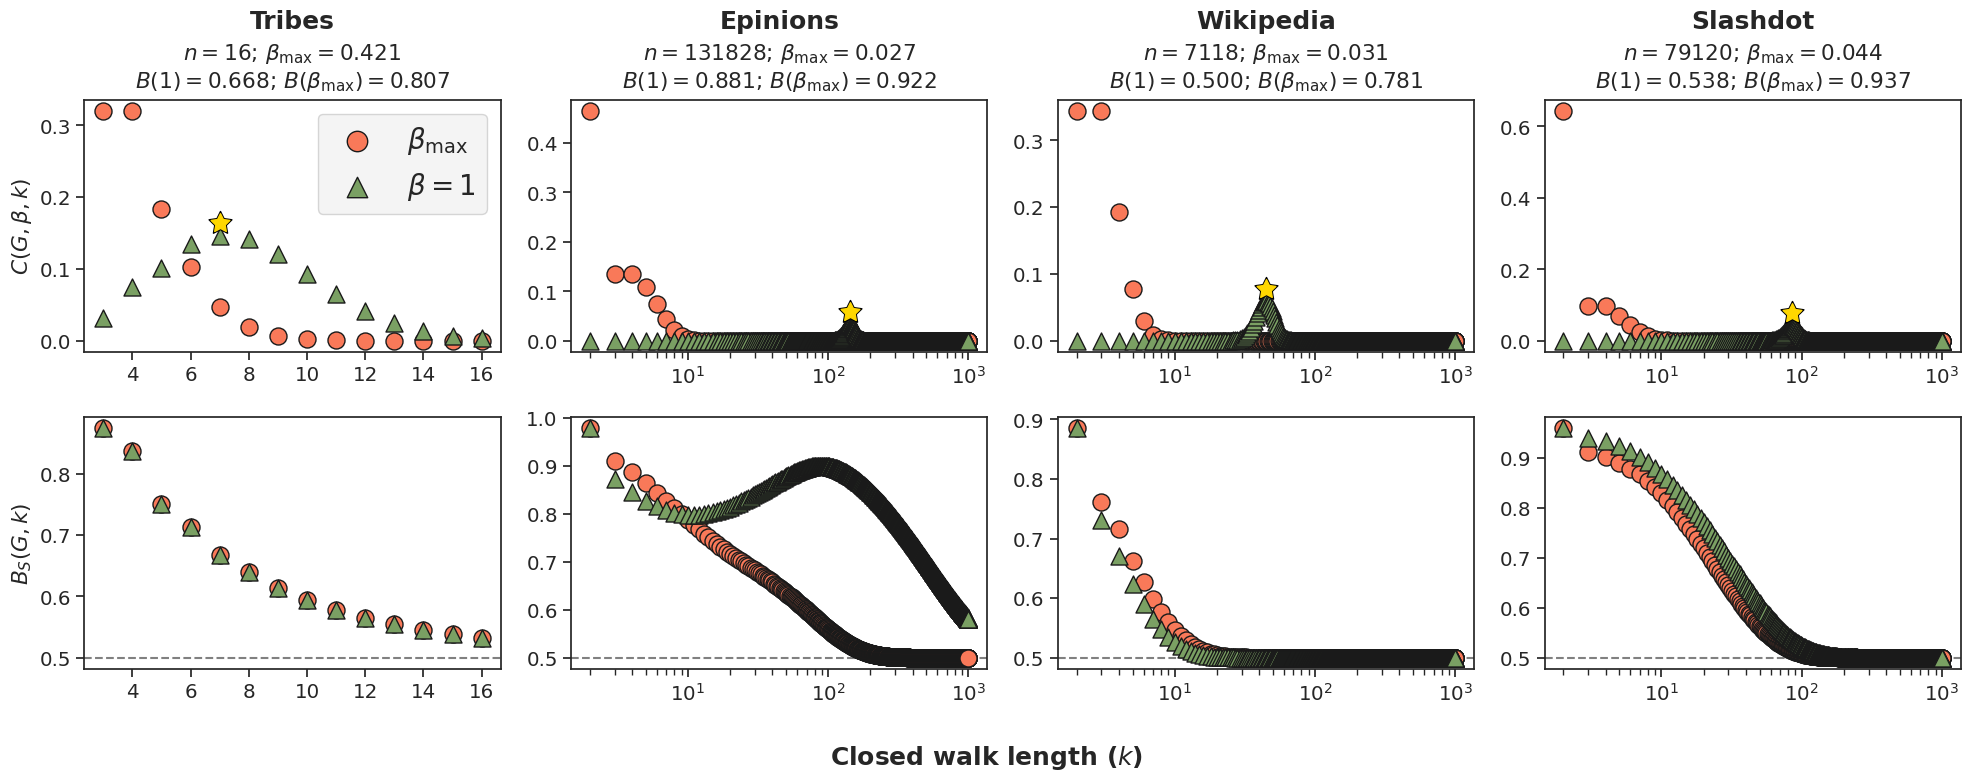

In [3]:
use = (
    "Tribes",
    "Epinions",
    "Wikipedia",
    "Slashdot"
)
balance = { k: v for k, v in BALANCE.items() if use and k in use }

fig, axes = plt.subplots(ncols=len(balance), nrows=2, figsize=(20, 8))

for kv, axrow in zip(balance.items(), axes.T): 
    name, B = kv
    B, W = B
    B.set_krange(B.kmin, kmax=1000)
    W.set_krange(W.kmin, kmax=1000)
    C0 = B.contrib().reset_index("beta", drop=True)
    C1 = W.contrib().reset_index("beta", drop=True)
    P1 = B.local_balance()
    P2 = W.local_balance()
    ax = axrow[0]
    skws = dict(s=150, edgecolors="k")
    ax.scatter(C0.index, C0, color=RED, label=r"$\beta_{\max}$", marker="o", **skws)
    ax.scatter(C1.index, C1, color=COLORS[0], label=r"$\beta = 1$", marker="^", **skws)
    ax.set_title(name, fontweight="bold", fontsize=18, y=1.25)
    dob0 = B.balance()
    dob1 = W.balance()
    info = rf"$n = {B.n_nodes}$; $\beta_{{\max}} = {B.beta:.3f}$" 
    dobs = rf"$B(1) = {dob1:.3f}$; $B(\beta_{{\max}}) = {dob0:.3f}$"
    ax.annotate(f"{info}\n{dobs}", (.5, 1.05), xycoords="axes fraction", ha="center")

    # Show peak for C1
    y0, y1 = ax.get_ylim()
    kpeak = C1.idxmax()
    peak  = C1.max()+(y1-y0)*.05
    ax.scatter(kpeak, peak, marker=(5,1), s=300, c="black")
    ax.scatter(kpeak, peak, marker=(5,1), s=200, c="gold")

    if name == "Tribes":
        ax.set_ylabel(r"$C(G, \beta, k)$")
        ax.legend(fontsize=20, markerscale=1.2, facecolor="#f2f2f2")

    ax = axrow[1]
    ax.scatter(P1.index, P1, color=RED, marker="o", **skws)
    ax.scatter(P2.index, P2, color=COLORS[0], marker="^", **skws)
    ax.axhline(.5, ls="--", color="gray", zorder=-10)
    
    if name == "Tribes":
        ax.set_ylabel(r"$B_S(G, k)$")

    for ax in axrow:
        if B.n_nodes >= 1000:
            ax.set_xscale("log")
        else:
            ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

fig.supxlabel(r"Closed walk length ($k$)", fontweight="bold", fontsize=18)
fig.tight_layout()

fig.savefig(FIGS/"contrib.png", bbox_inches="tight")

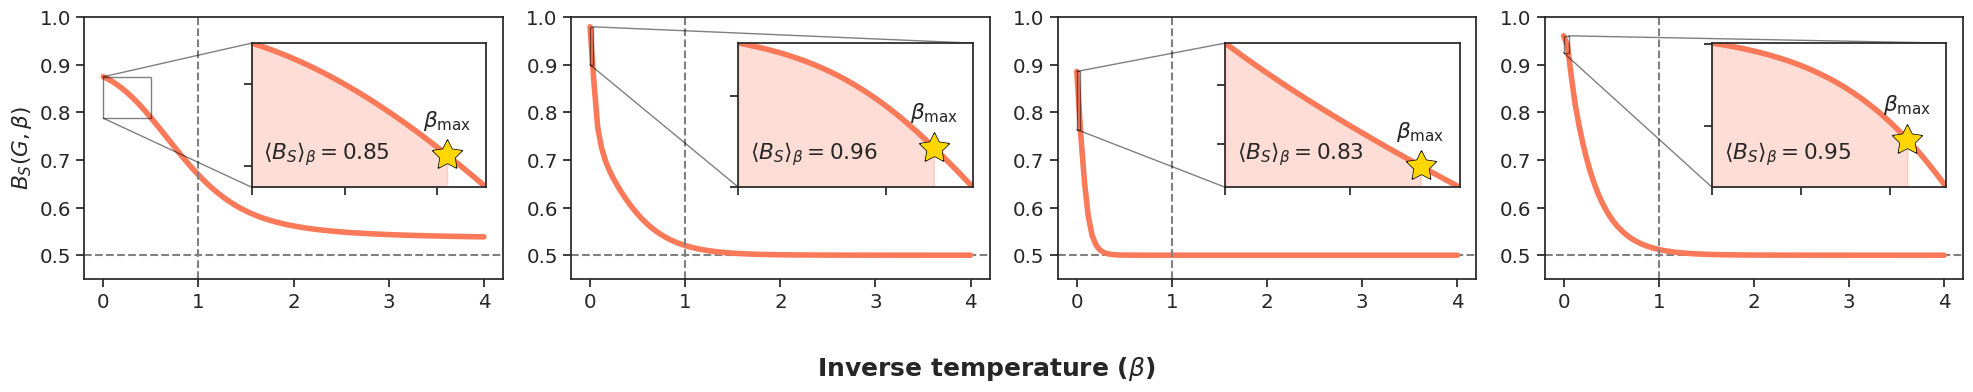

In [4]:
fig, axes = plt.subplots(ncols=len(balance), figsize=(20, 4))

for kv, ax in zip(BALANCE.items(), axes): 
    color = RED
    name, B = kv
    B, *_ = B
    bmin = np.finfo(float).eps 
    bmax = B.beta 
    dob = B.balance(B.B(bmin, 4, 100))
    ax.plot(dob.index, dob, linewidth=4, c=color)
    ax.axhline(.5, ls="--", c="gray", zorder=-10)
    ax.set_ylim(.45, 1)

    # Inset
    bmax *= 1.2
    dob_max = B.balance(bmin)
    dob_min = B.balance(bmax)
    xlim = (0, bmax)
    ylim = (dob_min, dob_max)
    bounds = [.4, .35, .56, .55]
    axin = ax.inset_axes(bounds)
    axin.set_xticklabels([]) 
    axin.set_yticklabels([]) 
    axin.set_xlim(*xlim)
    axin.set_ylim(*ylim)
    dob = B.balance(B.B(bmin, bmax, 100))
    axin.plot(dob.index, dob, linewidth=4, c=color)
    ax.indicate_inset_zoom(axin, edgecolor="black")

    # Average
    y0, y1 = ylim
    bmax = B.beta.max()
    dob  = B.balance(B.B(size=100))
    axin.fill_between(dob.index, y0, dob, color=color, alpha=.25)
    adob = dob.mean()
    text = rf"$\langle{{}}B_S\rangle_{{\beta}} = {adob:.2f}$"
    axin.annotate(text, (.05, .2), xycoords="axes fraction", ha="left")
    dob = B.balance()
    axin.scatter(bmax, dob, marker=(5, 1), s=500, c="black", zorder=99)
    axin.scatter(bmax, dob, marker=(5, 1), s=400, c="gold", zorder=99)
    axin.annotate(r"$\beta_{\max}$", (bmax, dob + .2*(y1-y0)), ha="center")
    
    if name == "Tribes":
        ax.set_ylabel(r"$B_S(G, \beta)$")

    ax.axvline(1, ls="--", color="gray")

fig.supxlabel(r"Inverse temperature ($\beta$)", fontweight="bold", fontsize=18)
fig.tight_layout()

fig.savefig(FIGS/"balance.pdf", bbox_inches="tight")